# Test Points
- Remove trunable before compile
- No compile for a generator
- Using a default optimizer without changing learning parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from importlib import reload

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras import models, layers, optimizers
from keras.layers import Dense, Input, Conv1D, Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


# Define Model

In [4]:
lr = 0.0002
adam = Adam(lr=lr, beta_1=0.5)
model_compile = lambda model: model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        D = models.Sequential()
        D.add(Dense(nh_D, activation='relu', input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))
        model_compile(D)
        
        G = models.Sequential() # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,))) # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1)) # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1)) # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1)) # (Batch, ni_D, 1)
        G.add(Flatten()) # (Batch, ni_D)
        model_compile(G)
        
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True

        self.D, self.G, self.GD = D, G, GD
        
    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = [1] * Real.shape[0] + [0] * Gen.shape[0]
        D.train_on_batch(X, y)
        
    def GD_train_on_batch(self, Z):
        GD, D = self.GD, self.D
        y = [1] * Z.shape[0]
        GD.train_on_batch(Z, y)

In [5]:
gan = GAN(ni_D=100, nh_D=50, nh_G=50)

# Load Data

In [6]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)
        # self.ni_D = ni_D

# Test train
- Testing training for G

# Define Machine

In [12]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        self.data = Data(0, 1, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)
        
        self.n_batch = n_batch
        # self.ni_D = ni_D
        
    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        
        # Real data
        Real = data.real_sample(n_batch) # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch) # (n_batch, ni_D)
        Gen = gan.G.predict(Z) # (n_batch, ni_D)
        # print(Gen.shape)
        
        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)
    
    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)        
        
        gan.D.trainable = False
        gan.GD_train_on_batch(Z)
    
    def train_each(self):
        self.train_D()
        self.train_GD()
    
    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()
            
    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z
        
    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)
        
    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
            
    def run(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)
        
    def run_loop(self, n_iter=100, epochs_each=1000, n_test=1000):
        for ii in range(n_iter):
            print('Stage', ii)
            machine.run(epochs_each, n_test)
            plt.show()        

In [13]:
machine = Machine(n_batch=10, ni_D=1000)

Stage 0


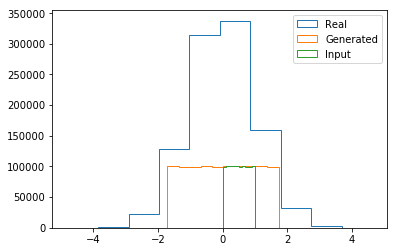

Stage 1


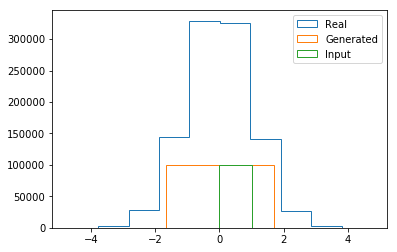

Stage 2


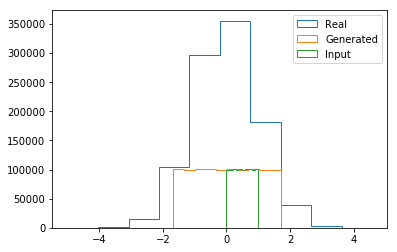

Stage 3


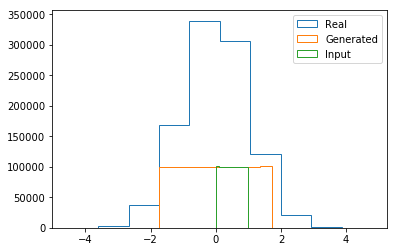

Stage 4


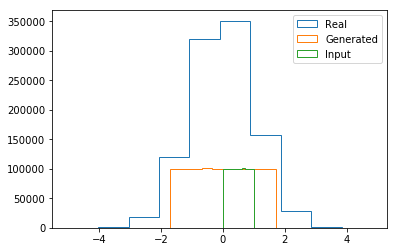

Stage 5


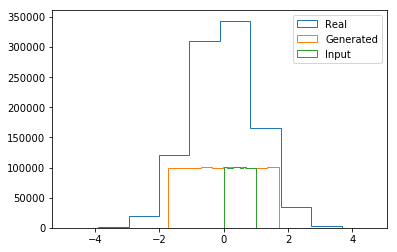

Stage 6


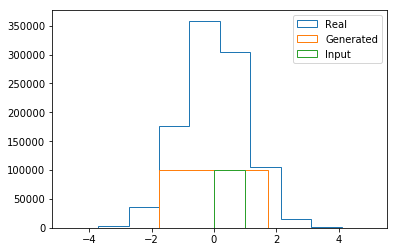

Stage 7


KeyboardInterrupt: 

In [14]:
machine.run_loop(100, 1000, 1000)